In [1]:
import numpy as np
import scipy.stats as spst

import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as spsp

import json
import re
from pandas.io.json import json_normalize

import scipy.optimize as spopt

import matplotlib as mpl

### The data in this .history file although have registered a startScraperDelay = 54000 they have been carried out at 29000 (end of 3.547GeV/c) there was an issue with Bryno application that has then been solved

In [2]:
#Import file with data scraper from AD
jsonFile = 'Data100MeVAcceptance.history'
# convert json file to pandas
# read scraper data from JSON
scraperData = []
with open(jsonFile) as infile:
    lines = infile.readlines()
    for i, line in enumerate(lines):
        try:
            scraperData.append(json.loads(line))
        except:
            print('something wrong with line {}'.format(i))

scraperDataPD23August2023 = json_normalize(scraperData, max_level=2)

/tmp/ipykernel_1102/3622584122.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  scraperDataPD23August2023 = json_normalize(scraperData, max_level=2)


In [3]:
#Import file with data scraper from AD
jsonFile = 'Acceptance100MeV_30August2023.history'
# convert json file to pandas
# read scraper data from JSON
scraperData = []
with open(jsonFile) as infile:
    lines = infile.readlines()
    for i, line in enumerate(lines):
        try:
            scraperData.append(json.loads(line))
        except:
            print('something wrong with line {}'.format(i))

scraperDataPD30August2023 = json_normalize(scraperData, max_level=2)

/tmp/ipykernel_1102/1587266494.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  scraperDataPD30August2023 = json_normalize(scraperData, max_level=2)


In [4]:
#Import file with data scraper from AD
jsonFile = 'Emittance100MeV_30August2023.history'
# convert json file to pandas
# read scraper data from JSON
scraperData = []
with open(jsonFile) as infile:
    lines = infile.readlines()
    for i, line in enumerate(lines):
        try:
            scraperData.append(json.loads(line))
        except:
            print('something wrong with line {}'.format(i))

EmittancePD30August2023 = json_normalize(scraperData, max_level=2)

/tmp/ipykernel_1102/2719371384.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  EmittancePD30August2023 = json_normalize(scraperData, max_level=2)


In [5]:
df = pd.concat([scraperDataPD23August2023, scraperDataPD30August2023.iloc[-11:]])

# Plot non-normalised losses and scraper velocity

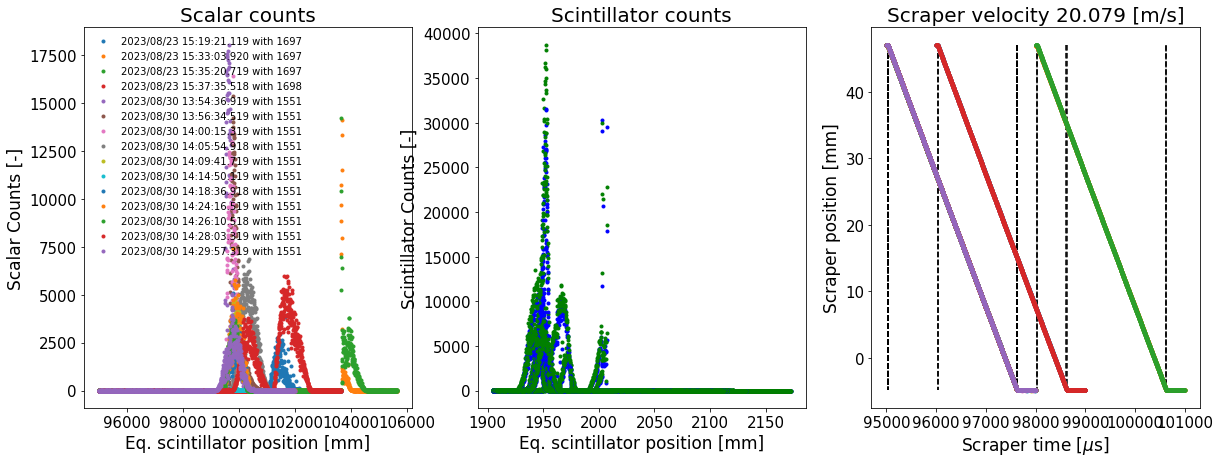

In [6]:
f, ax = plt.subplots(1, 3, figsize = (20, 7), sharex = False, sharey = False)
for h in range(len(df.originUtcTime.values)):

    ScraperStart = np.where(np.diff(np.array(df.scraperY.iloc[h]))<-0.03)[0][0]
    ScraperEnd = np.where(np.diff(np.array(df.scraperY.iloc[h]))<-0.03)[0][-1]

    delta_time_scraper = np.abs(df.scraperXms.iloc[h][ScraperStart] - df.scraperXms.iloc[h][ScraperEnd] )

    VelocityScraper = (max(df.scraperY.iloc[h]) - min(df.scraperY.iloc[h])) / delta_time_scraper

    # scalar plot
    ax[0].set_title("Scalar counts", size = 20)
    
    limit = 0.01
    ydata_scalar = df["det3.yval"].iloc[h][0][::-1]
    xdata_scalar = np.array(df["det3.xms"].iloc[h])# * VelocityScraper
#     print(max(xdata_scalar)- min(xdata_scalar))
    
    ax[0].plot( xdata_scalar, ydata_scalar, ".", label = "%s with %1.0f"%(df["dataScraperOriginTime"].iloc[h], len(xdata_scalar)) )
    
    ax[0].set_xlabel("Eq. scintillator position [mm]", size = 17)
    ax[0].set_ylabel("Scalar Counts [-]", size = 17)
    ax[0].tick_params(axis = "both", which = "major", labelsize = 15)
    
    # scintillator plot
    ax[1].set_title("Scintillator counts", size = 20)
    xdata_scint = np.array(df["det1.xms"].iloc[h])*VelocityScraper
    ydata_scint1 = np.array(df["det1.yval"].iloc[h][1])
    ydata_scint2 = np.array(df["det1.yval"].iloc[h][0])
    ax[1].plot( xdata_scint, ydata_scint1, ".b" )
    ax[1].plot( xdata_scint, ydata_scint2, ".g" )
    
    ax[1].set_xlabel("Eq. scintillator position [mm]", size = 17)
    ax[1].set_ylabel("Scintillator Counts [-]", size = 17)
    ax[1].tick_params(axis = "both", which = "major", labelsize = 15)
    
    # scraper plot
    ax[2].set_title("Scraper velocity %1.3f [m/s]"%(VelocityScraper*1e3), size = 20)
    ax[2].plot(df["scraperXms"].iloc[h], df["scraperY"].iloc[h], ".", label = "%s"%df["dataScraperOriginTime"].iloc[h] )
    
    ax[2].vlines(x = df["scraperXms"].iloc[h][ScraperStart],ymin = max(df["scraperY"].iloc[h]), ymax = min(df["scraperY"].iloc[0]), 
                 color = "k", ls = "--")
    ax[2].vlines(x = df["scraperXms"].iloc[h][ScraperEnd],ymin = max(df["scraperY"].iloc[h]), ymax = min(df["scraperY"].iloc[0]), 
                 color = "k", ls = "--")
    
    ax[2].set_xlabel(r"Scraper time [$\mu$s]", size = 17)
    ax[2].set_ylabel("Scraper position [mm]", size = 17)
    ax[2].tick_params(axis = "both", which = "major", labelsize = 15)
ax[0].legend(frameon = False)

# Reconstruction beam profile with the ABEL transform and fit - COMPARISON

In [7]:
def ScraperLosses_V (x_scraper, RMS_emittance, x0):
    beta_scraper = 4.288 #m
    y = (x_scraper-x0)/beta_scraper/RMS_emittance * np.exp(- 0.5 * (x_scraper-x0)**2/beta_scraper/RMS_emittance )
    return y

def ScraperLosses_H (x_scraper, RMS_emittance, x0):
    beta_scraper = 4.975 #m
    y = (x_scraper-x0)/beta_scraper/RMS_emittance * np.exp(- 0.5 * (x_scraper-x0)**2/beta_scraper/RMS_emittance )
    return y

In [8]:
def Gauss_Fit_V (x, ampl, RMS_emittance):
    beta_scraper = 4.288
    y = ampl * 1/np.sqrt(2.*np.pi*beta_scraper*RMS_emittance) * np.exp( -0.5 * (x)**2 / (beta_scraper*RMS_emittance))
#     print("V***", np.sqrt(beta_scraper*RMS_emittance)*1e3, "***")
    return y

def Gauss_Fit_H (x, ampl, RMS_emittance):
    beta_scraper = 4.975
    y = ampl * 1/np.sqrt(2.*np.pi*beta_scraper*RMS_emittance) * np.exp( -0.5 * (x)**2 / (beta_scraper*RMS_emittance))
#     print("H***", np.sqrt(beta_scraper*RMS_emittance)*1e3, "***")
    return y

In [9]:
def ForwardAbelTransform (*InputVariables, MinValueLosses, MinPointsInRisingEdge, MaximumOffset):
    if len(InputVariables) == 0:
        print("Error, you didn't put any input variable, please enter variables: scraper position and scintillator losses")
    elif len(InputVariables) == 1:
        print("Error, you didn't put all the needed variable, please enter variables BOTH: scraper position and scintillator losses")
    elif len(InputVariables) > 2:
        print("Error, too many input variables, please check input variables")
    elif len(InputVariables) == 2:
        print("Valid, all the needed variables have been inserted")
        
        
        ScraperPos = InputVariables[0]
        Losses = InputVariables [1] / max(InputVariables [1] )
        ##UPGRADE: find the first non-zero point
        Ind_LargerZero = np.where(Losses>MinValueLosses)[0][0]
        print("First non-zero point in losses", Ind_LargerZero)  
        if Ind_LargerZero == 0:
            CumulativeFunction = [] # Function where I collect the value of the integrals
        else:
            CumulativeFunction = np.ones(Ind_LargerZero) * np.nan
        ##UPGRADE: try to add oversampling if not enough points on the rising edge of the losses
        # In this configuration we are in the linear regime --> linear interpolation
        Ind_maxLosses = np.argmax(Losses) + MaximumOffset
        
        df = pd.DataFrame()
        df["x"] = ScraperPos
        df["y"] = Losses
        # start of oversampling
#         plt.figure()
#         plt.plot(ScraperPos, Losses, ".b")
        while(len(Losses[Ind_LargerZero:Ind_maxLosses+1])<MinPointsInRisingEdge):
            df_OverSampling = pd.DataFrame()
            AdditionalPoint_x, AdditionalPoint_y = np.array([]), np.array([])

            if len(Losses[Ind_LargerZero:Ind_maxLosses+1])<MinPointsInRisingEdge:
                #print("On the rising edge of the losses there are less than %i points, oversampling is performed"%MinPointsInRisingEdge)
                #AdditionalPoint_x, AdditionalPoint_y = np.zeros(Ind_maxLosses+1-Ind_LargerZero), np.zeros(Ind_maxLosses+1-Ind_LargerZero)
                for k, point in enumerate(Losses[Ind_LargerZero:Ind_maxLosses+1]):
                    AdditionalPoint_x = np.append(AdditionalPoint_x, ScraperPos[k+Ind_LargerZero] + (ScraperPos[(k+1)+Ind_LargerZero] - ScraperPos[k+Ind_LargerZero])/2)
                    AdditionalPoint_y = np.append(AdditionalPoint_y, Losses[k+Ind_LargerZero] + (Losses[(k+1)+Ind_LargerZero] - Losses[k+Ind_LargerZero])/2)
        
            df_OverSampling["x"] = AdditionalPoint_x
            df_OverSampling["y"] = AdditionalPoint_y
            df = pd.concat([df, df_OverSampling], ignore_index = True)
            df = df.sort_values(by=['x'])
            
            Ind_LargerZero = np.where(Losses>MinValueLosses)[0][0]
            Ind_maxLosses = np.argmax(Losses) + MaximumOffset
                        
            ScraperPos = df.x.values
            Losses = df.y.values
            
#             plt.plot(AdditionalPoint_x, AdditionalPoint_y, "xr")
            #plt.xlim([-1, 20])
        
        # Compute dx for the Abel Transform, dx is centred w.r.t. the numerical/experimental point --> rectangular integral
        dx = np.zeros(len(ScraperPos))
        for i in range(len(ScraperPos)):
            if i == 0 or i == len(ScraperPos)-1:
                dx[0] = (ScraperPos[1]-ScraperPos[0])*0.5
                dx[-1] = (ScraperPos[-1]-ScraperPos[-2])*0.5
            else:
                dx[i] = ((ScraperPos[i+1] - ScraperPos[i])*0.5 + ScraperPos[i]) - ((ScraperPos[i] - ScraperPos[i-1])*0.5 + ScraperPos[i-1])
        # Rectangular integral definition
        for h, y in enumerate(ScraperPos[Ind_LargerZero:], start = Ind_LargerZero):
            Numerator = Losses[h+1:] * dx[h+1:]
            x = ScraperPos[h+1:]
            # Denominator = np.append(1, np.sqrt(x[1:]**2 - y**2))
            Denominator = np.sqrt((x-ScraperPos[Ind_LargerZero])**2 - (y-ScraperPos[Ind_LargerZero])**2)

            temp = Numerator/Denominator

            CumulativeFunction = np.append(CumulativeFunction, sum(temp)/np.pi)
#         print(Ind_maxLosses)
        # calculation of the HWHM
        #plt.figure()
        #print("HFWM", ScraperPos[np.where(max(CumulativeFunction[Ind_LargerZero+1:])/2>CumulativeFunction[Ind_LargerZero+1:])[0][0]+Ind_LargerZero+1]*np.sqrt(2.*np.log(2))*1e-3)
        #plt.plot(ScraperPos[np.where(max(CumulativeFunction[Ind_LargerZero+1:])/2>CumulativeFunction[Ind_LargerZero+1:])[0][0]+Ind_LargerZero+1], CumulativeFunction[np.where(max(CumulativeFunction[Ind_LargerZero+1:])/2>CumulativeFunction[Ind_LargerZero+1:])[0][0]+Ind_LargerZero+1], "sg")
        #plt.plot(ScraperPos, CumulativeFunction, ".m")
        #plt.plot([0, 10], [max(CumulativeFunction[Ind_LargerZero+1:])/2, max(CumulativeFunction[Ind_LargerZero+1:])/2], "-r")
    return CumulativeFunction[~np.isnan(CumulativeFunction)], Ind_LargerZero, ScraperPos[~np.isnan(CumulativeFunction)]

# compute acceptance by measuring the 0-to-0 size of the beam between losses

scalar 1407 1109 26.54042905092024 -0.4527974212121535
scint 893 758 26.691748561738677 -0.4013848539098035
scalar 1330 1253 6.871822445567432 -0.09040211398496467
scint 857 824 6.611854176335328 0.0
scalar 1439 1253 16.760123526030384 -0.09057965003103163
scint 908 824 16.863232718573727 0.0
scalar 1454 1159 26.272309154458526 -0.4529194547078532
scint 914 780 26.49940358267895 -0.40150097561081566
scalar 1204 996 18.725834984005587 -0.09046626809913505
scint 867 774 18.64240937163413 0.0
scalar 1282 1029 22.66048879906748 -0.271964265867382
scint 902 789 22.697001972422186 0.0
scalar 1196 990 18.379780895530303 -0.27157764796038464
scint 864 771 18.45689540949843 -0.2006209962801222
scalar 1344 1048 26.307056474958472 -0.5441861891522422
scint 930 797 26.332884091822507 -0.4020288040428568
scalar 1194 988 18.002327897622763 -0.6332623884084114
scint 863 770 18.242040694525258 -0.4009291595293689
scalar 1549 3 139.87798384671873 -0.0905180446943632
scint 1023 325 139.62889873082167 -0

/tmp/ipykernel_1102/464252416.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, 2, figsize = (14, 7), sharex = False, sharey = False)


scalar 1195 989 18.10622578777884 -0.5432484521379592
scint 863 770 18.255435386179215 -0.40122355216635697
scalar 1176 987 16.65581355301697 -0.45286844893848865
scint 855 770 16.84950389585856 -0.20059189963694735
scalar 1344 1056 25.562754906756254 -0.54385317381616
scint 930 801 25.509344520465675 -0.401722001440703
scalar 1222 929 25.73484335518242 -0.8154479043600986
scint 875 743 25.70169331114994 -0.803177915973265


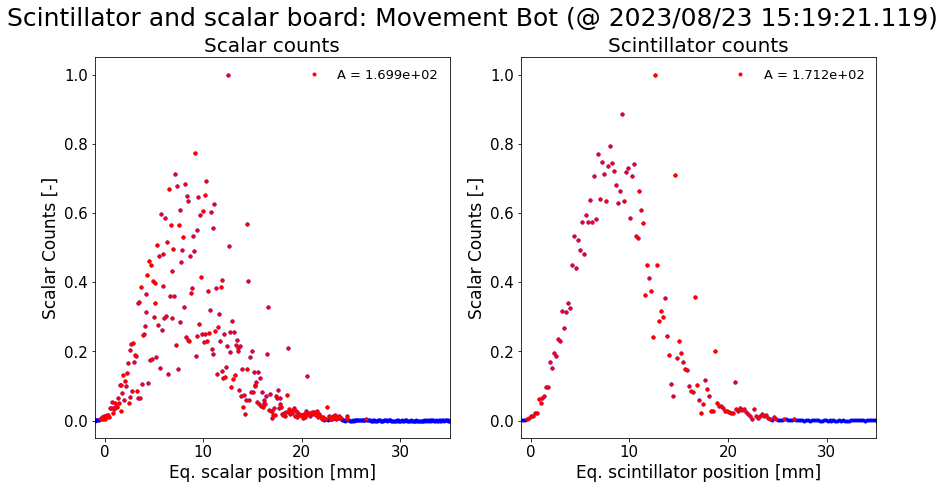

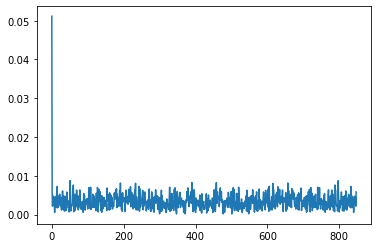

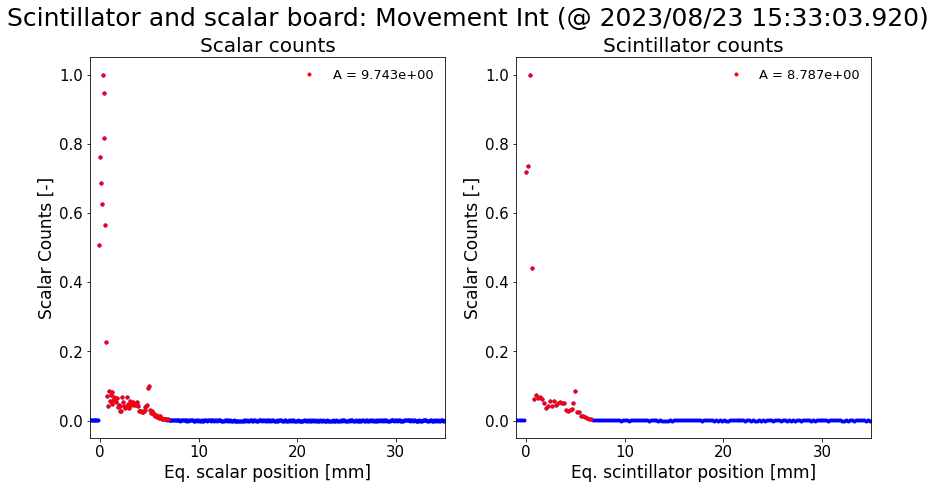

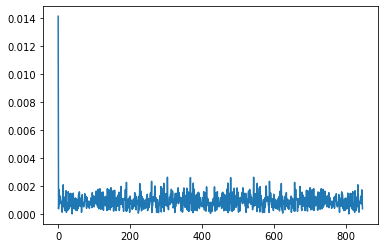

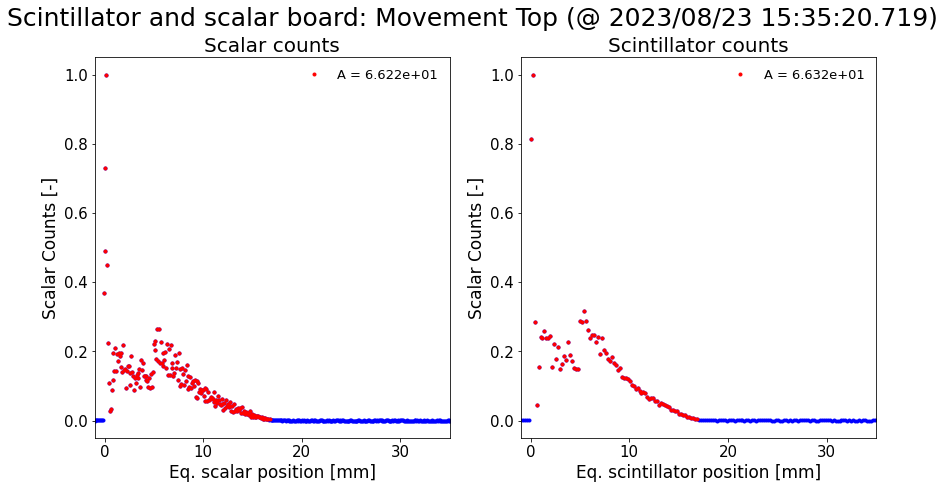

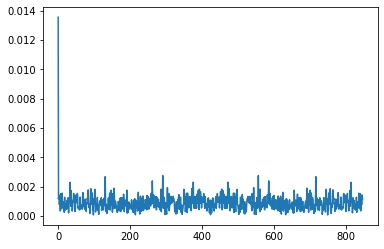

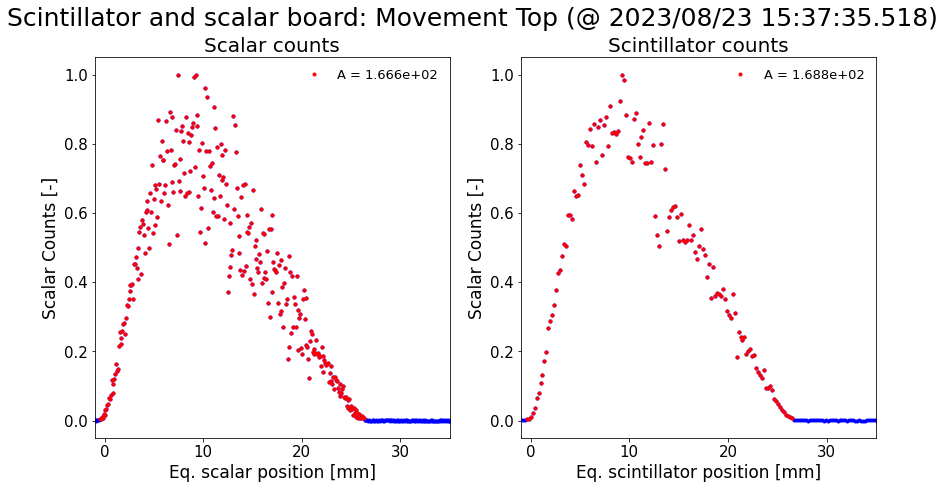

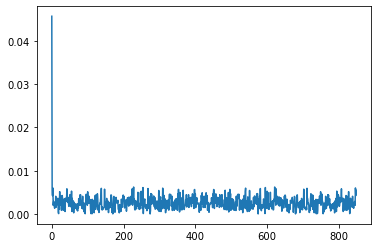

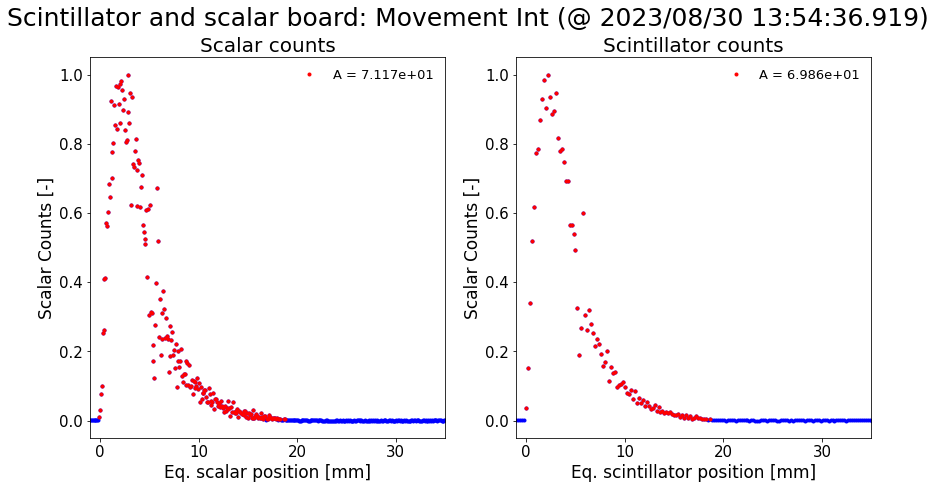

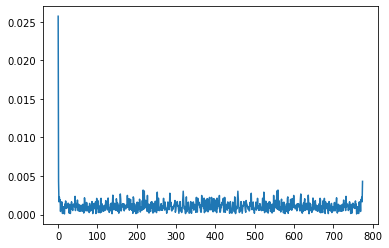

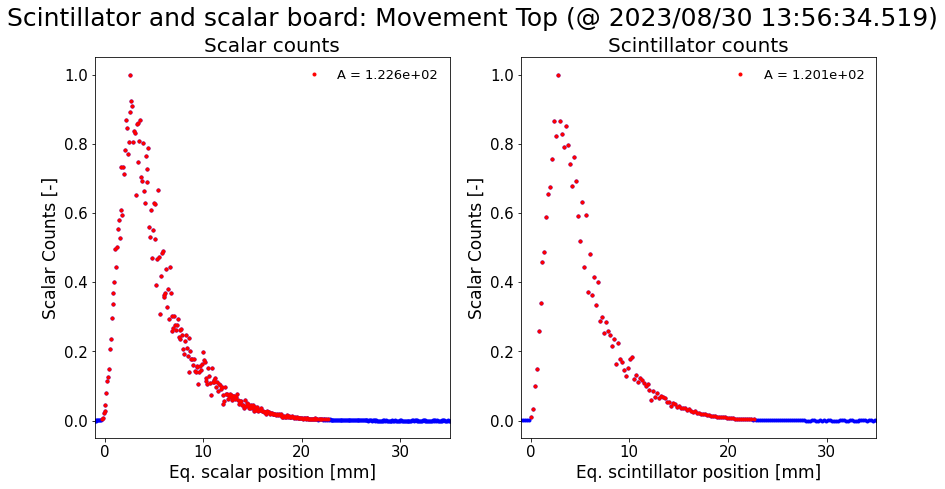

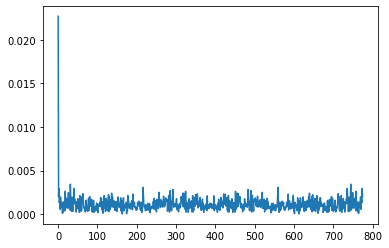

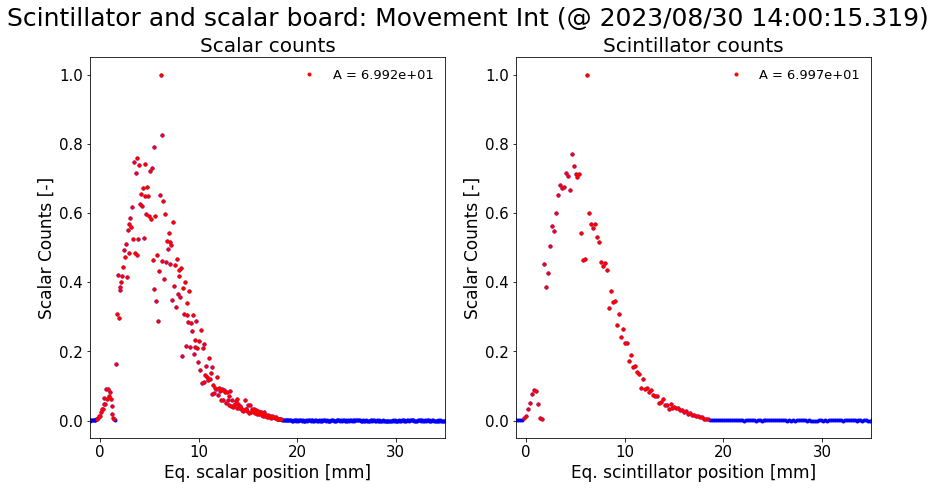

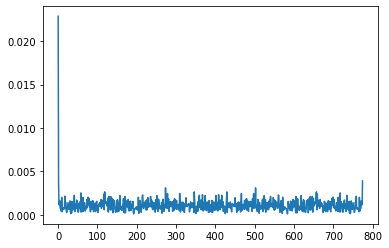

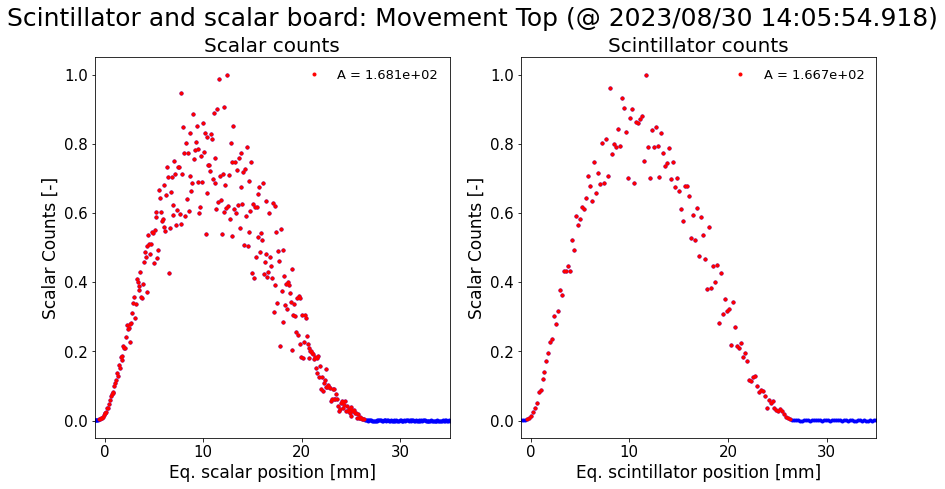

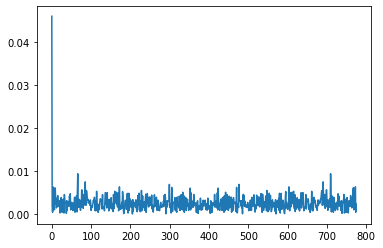

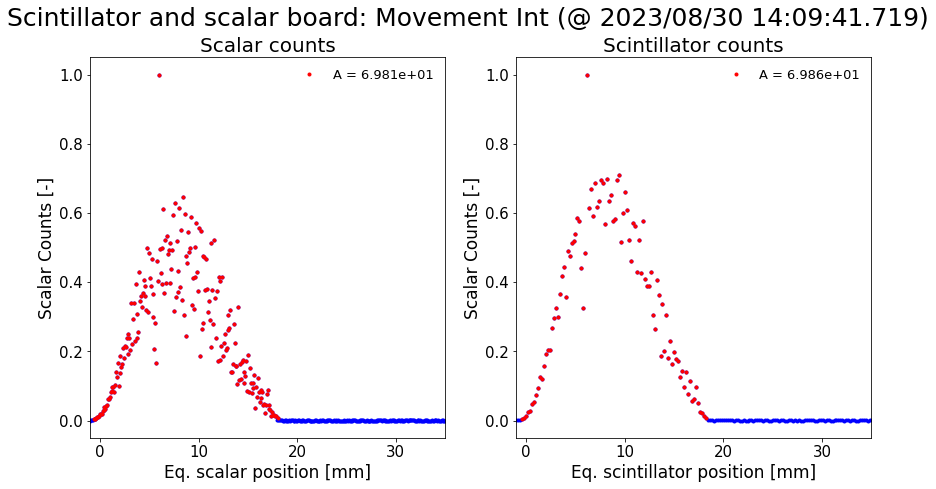

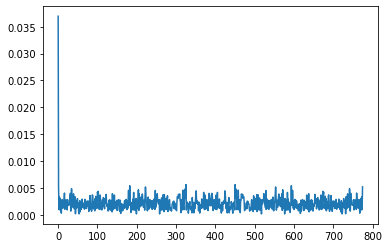

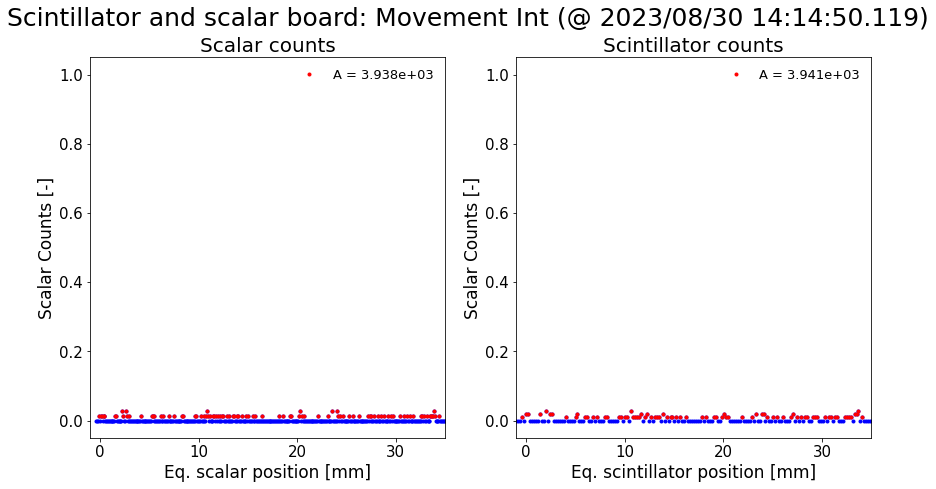

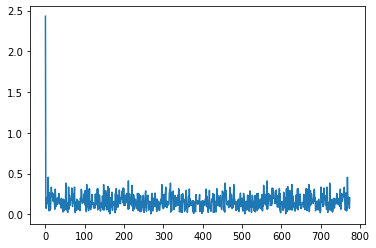

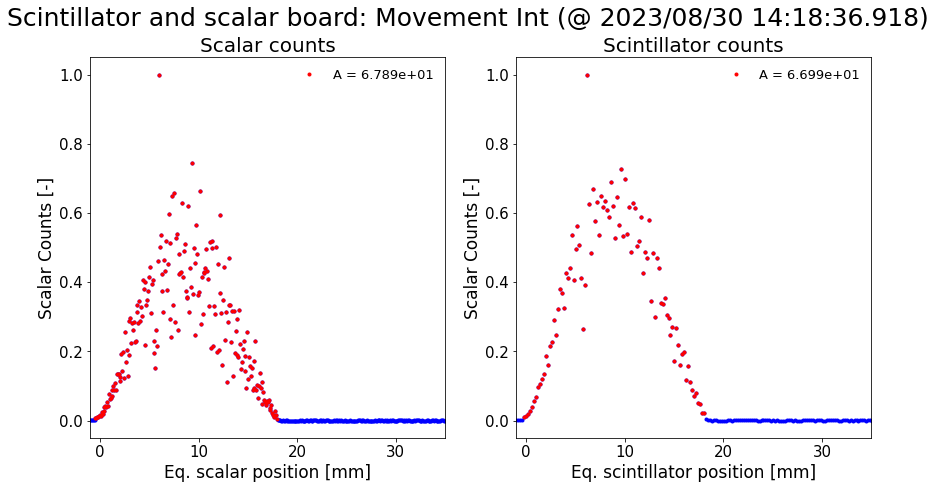

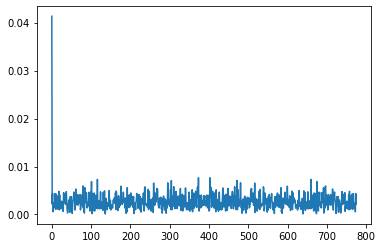

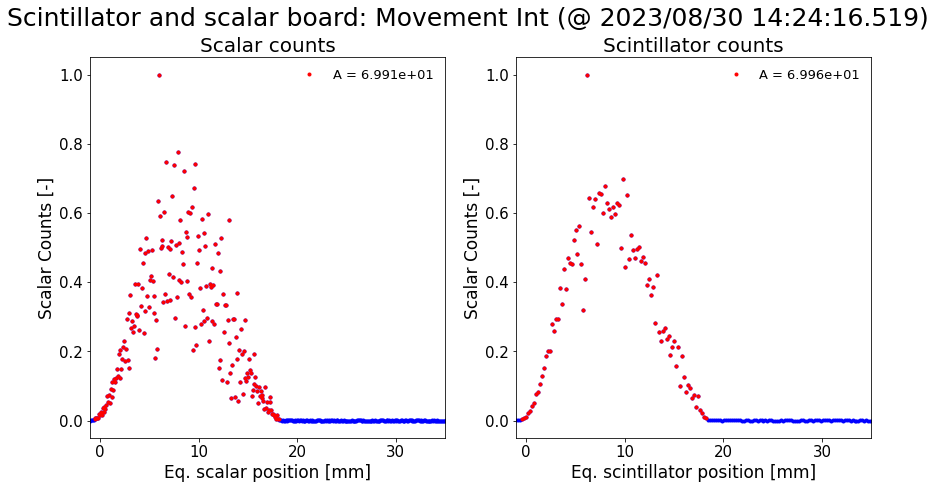

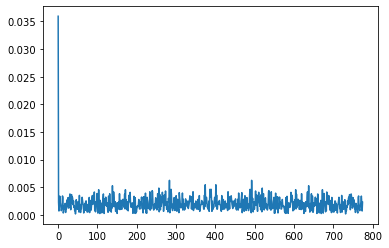

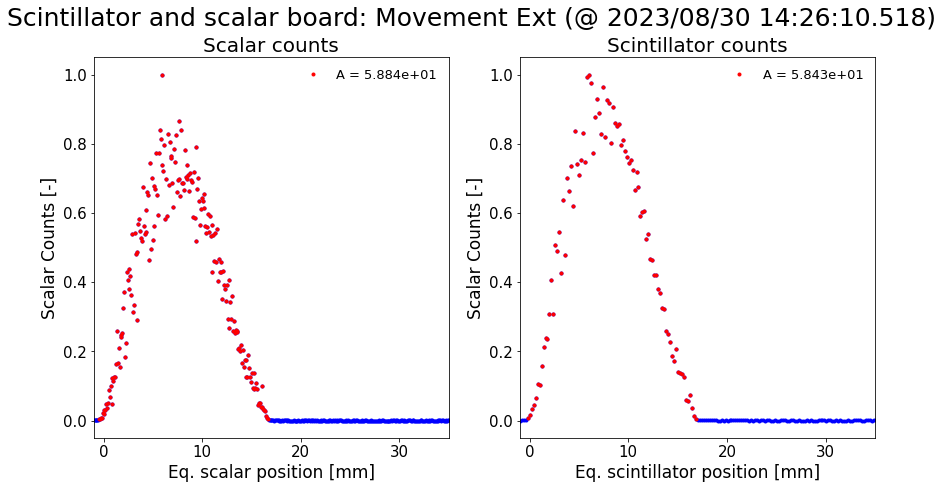

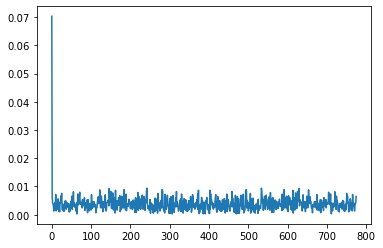

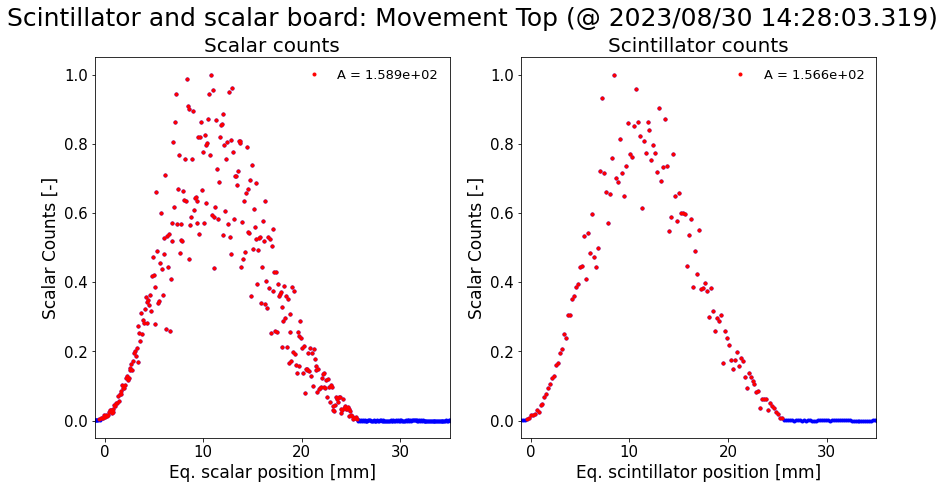

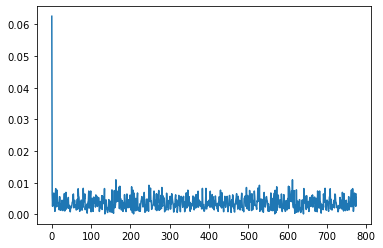

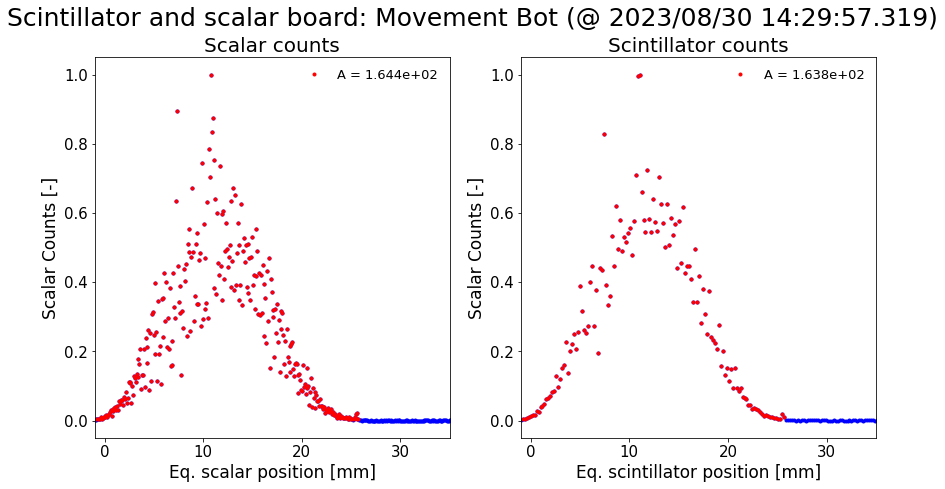

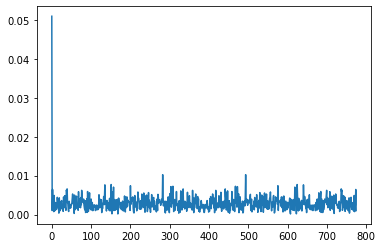

In [13]:
Acceptance_Scalar = []
Acceptance_Scintillator = []

for h in range(len(df.originUtcTime.values)):
    
    f, ax = plt.subplots(1, 2, figsize = (14, 7), sharex = False, sharey = False)
    f.suptitle("Scintillator and scalar board: Movement %s (@ %s)"%(df.scraperDirection.iloc[h], df.dataScraperOriginTime.iloc[h]), size = 25)
    
    if (df.scraperDirection.iloc[h] == "Bot") or (df.scraperDirection.iloc[h] == "Top"):
        beta_scraper = 4.288
        ScraperLossesFit = ScraperLosses_V
        GaussFit = Gauss_Fit_V
    else:
        beta_scraper = 4.975
        ScraperLossesFit = ScraperLosses_H
        GaussFit = Gauss_Fit_H
    
    ScraperStart = np.where(np.diff(np.array(df.scraperY.iloc[h]))<-0.03)[0][0]
    ScraperEnd = np.where(np.diff(np.array(df.scraperY.iloc[h]))<-0.03)[0][-1]

    delta_time_scraper = np.abs(df.scraperXms.iloc[h][ScraperStart] - df.scraperXms.iloc[h][ScraperEnd] )

    VelocityScraper = (max(df.scraperY.iloc[h]) - min(df.scraperY.iloc[h])) / delta_time_scraper
    
    #################################################    scalar plot     #################################################
    ax[0].set_title("Scalar counts", size = 20)

    ydata_scalar = np.array(df["det3.yval"].iloc[h][0])[::-1]
    xdata_scalar = np.array(df["det3.xms"].iloc[h]) * VelocityScraper
    
    ind = np.where(ydata_scalar/max(ydata_scalar)>0.003)[0]
    limit = 0.01
    
    ind_minlosses = np.where(ydata_scalar/max(ydata_scalar)>limit)[0][0]+1
    if np.mean(ydata_scalar)>1:
        
        ind = np.where(ydata_scalar/max(ydata_scalar)>0.003)[0]
        
        ax[0].plot( xdata_scalar-xdata_scalar[ind_minlosses], ydata_scalar/max(ydata_scalar), ".b" )
        ax[0].plot( xdata_scalar[ind]-xdata_scalar[ind_minlosses], ydata_scalar[ind]/max(ydata_scalar), ".r", label = "A = %1.3e"%((xdata_scalar[ind[-1]]-xdata_scalar[ind[0]])**2/beta_scraper))

        Acceptance_Scalar = np.append(Acceptance_Scalar, (xdata_scalar[ind[-1]]-xdata_scalar[ind[0]])**2/beta_scraper)
        print("scalar", ind[-1], ind[0], xdata_scalar[ind[-1]]- xdata_scalar[ind_minlosses], xdata_scalar[ind[0]]- xdata_scalar[ind_minlosses])
        ax[0].set_xlabel("Eq. scalar position [mm]", size = 17)
        ax[0].set_ylabel("Scalar Counts [-]", size = 17)
        ax[0].tick_params(axis = "both", which = "major", labelsize = 15)
        ax[0].legend(prop = {"size":13}, frameon = False)
        ax[0].set_xlim([-1, 35])
    else:
        Acceptance_Scalar = np.append(Acceptance_Scalar, np.nan)
        
    plt.figure()
    plt.plot(np.abs(np.fft.fft(ydata_scalar[:int(len(ydata_scalar)/2)]/max(ydata_scalar))))

        
#     #################################################    scintillator plot     #################################################
    ax[1].set_title("Scintillator counts", size = 20)
    xdata_scint = np.array(df["det1.xms"].iloc[h])*VelocityScraper
    ydata_scint = np.array(df["det1.yval"].iloc[h][0])[::-1]
    ind_minlosses = np.where(ydata_scint/max(ydata_scint)>limit)[0][0]
    
    ind = np.where(ydata_scint/max(ydata_scint)>0.003)[0]
    
    ax[1].plot( xdata_scint - xdata_scint[ind_minlosses], ydata_scint/max(ydata_scint), ".b" )
    ax[1].plot( xdata_scint [ind] - xdata_scint[ind_minlosses], ydata_scint[ind]/max(ydata_scint), ".r", label = "A = %1.3e"%((xdata_scint[ind[-1]]-xdata_scint[ind[0]])**2/beta_scraper ))

    Acceptance_Scintillator = np.append(Acceptance_Scintillator, (xdata_scint[ind[-1]]-xdata_scint[ind[0]])**2/beta_scraper)
    print("scint", ind[-1], ind[0], xdata_scint[ind[-1]]-xdata_scint[ind_minlosses], xdata_scint[ind[0]]-xdata_scint[ind_minlosses])
    ax[1].set_xlabel("Eq. scintillator position [mm]", size = 17)
    ax[1].set_ylabel("Scalar Counts [-]", size = 17)
    ax[1].tick_params(axis = "both", which = "major", labelsize = 15)
    ax[1].legend(prop = {"size":13}, frameon = False)
    ax[1].set_xlim([-1, 35])

In [11]:
df["AcceptanceScalar"] = Acceptance_Scalar
df["AcceptanceScintillator"] = Acceptance_Scintillator

# Compute acceptance with fit and reconstructing Gaussian profile

No handles with labels found to put in legend.


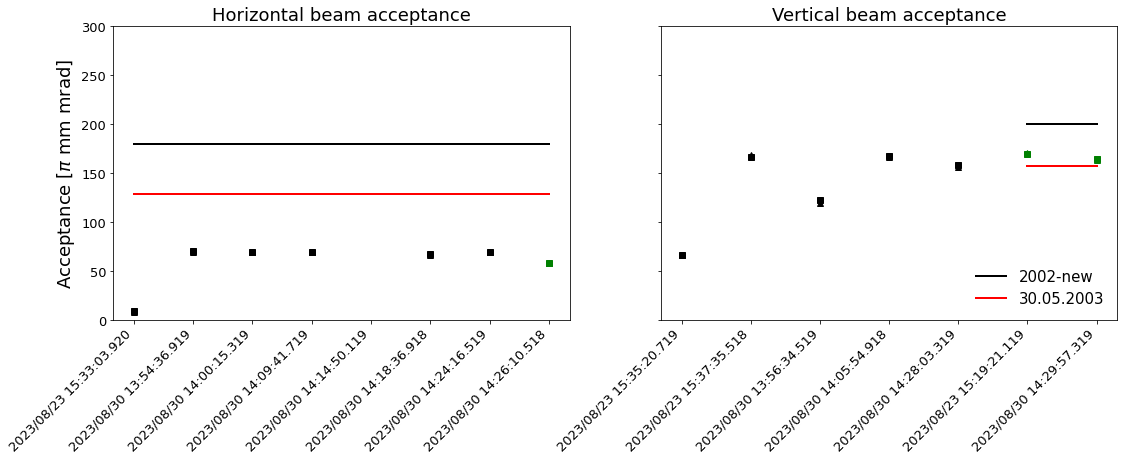

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6), sharex = False, sharey = True)


ax1.set_title("Horizontal beam acceptance", size = 18)

ax1.plot(df[(df["scraperDirection"] == "Int") ].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Int") ].AcceptanceScalar, "sk")
ax1.plot(df[(df["scraperDirection"] == "Int") ].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Int") ].AcceptanceScintillator, "^k")

ax1.plot(df[ (df["scraperDirection"] == "Ext")].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Ext")].AcceptanceScalar, "sg")
ax1.plot(df[ (df["scraperDirection"] == "Ext")].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Ext")].AcceptanceScintillator, "^g")

# ax1.plot(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime,
#          df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].Integral_Scalar_Losses, "sg")
# ax1.plot(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime,
#          df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].Integral_Scintillator_Losses, "^g")

ax1.plot([min(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime),
          max(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime)],[180, 180], "-k", lw = 2)
# ax1.plot([min(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime),
#           max(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime)],[165, 165], "--k", lw = 2)
## acceptance from Pavel measurements on the 30th of May 2003
# ax1.plot([min(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime),
#           max(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime)],[147, 147], "--r", lw = 2)
ax1.plot([min(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime),
          max(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime)],[129, 129], "-r", lw = 2)

ax1.legend(prop = {"size":15}, frameon = False, loc = 2)
ax1.tick_params(axis = "both", which = "major", labelsize = 13)
ax1.set_ylabel ("Acceptance [$\pi$ mm mrad]", size = 18)


ax2.set_title("Vertical beam acceptance", size = 18)

ax2.plot(df[ (df["scraperDirection"] == "Top")].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Top")].AcceptanceScalar, "sk")
ax2.plot(df[ (df["scraperDirection"] == "Top")].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Top")].AcceptanceScintillator, "^k")

ax2.plot(df[(df["scraperDirection"] == "Bot") ].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Bot") ].AcceptanceScalar, "sg")
ax2.plot(df[(df["scraperDirection"] == "Bot") ].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Bot") ].AcceptanceScintillator, "^g")
# ax2.plot(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime,
#          df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].Integral_Scalar_Losses, "sg")
# ax2.plot(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime,
#          df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].Integral_Scintillator_Losses, "^g")

ax2.plot([min(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime),
          max(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime)],[200, 200], "-k", lw = 2, label = "2002-new")
# ax2.plot([min(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime),
#           max(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime)],[180, 180], "--k", lw = 2, label = "2002-old")
## acceptance from Pavel measurements on the 30th of May 2003
# ax2.plot([min(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime),
#           max(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime)],[166, 166], "--r", lw = 2, label = "30.05.2003")
ax2.plot([min(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime),
          max(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime)],[158, 158], "-r", lw = 2, label = "30.05.2003")


ax2.legend(prop = {"size":15}, frameon = False, loc = 4)
ax2.tick_params(axis = "both", which = "major", labelsize = 13)

ax1.set_ylim([0, 300])

f.autofmt_xdate(rotation=45)

# evolution beam along the 100MeV/c plateaux

In [13]:
df_100 = pd.concat([scraperDataPD30August2023.iloc[:2], scraperDataPD30August2023.iloc[6:8], EmittancePD30August2023])

In [14]:
df_100 = df_100.sort_values(by=["startScraperDelay"])

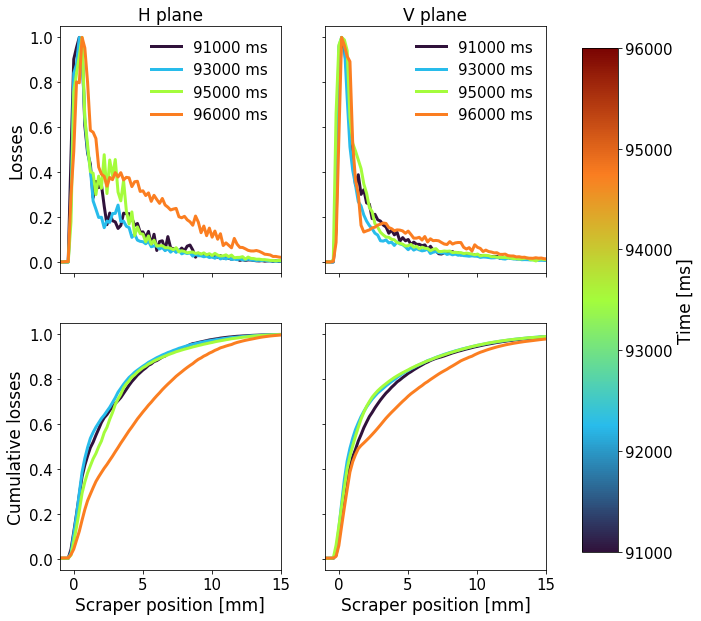

In [15]:
f, ax = plt.subplots(2, 2, figsize = (10, 10), sharex = True, sharey = True)

normalize = mpl.colors.Normalize(vmin=91000, vmax=96000)
colormap = mpl.cm.turbo(np.linspace(0,1,5))

ax1, ax2 = ax[0,0], ax[0,1]
ax3, ax4 = ax[1,0], ax[1,1]
                        
j = 0

for h, data in enumerate(df_100["startScraperDelay"].values):
    
    ScraperStart = np.where(np.diff(np.array(df_100.scraperY.iloc[h]))<-0.03)[0][0]
    ScraperEnd = np.where(np.diff(np.array(df_100.scraperY.iloc[h]))<-0.03)[0][-1]

    delta_time_scraper = np.abs(df_100.scraperXms.iloc[h][ScraperStart] - df_100.scraperXms.iloc[h][ScraperEnd] )

    VelocityScraper = (max(df_100.scraperY.iloc[h]) - min(df_100.scraperY.iloc[h])) / delta_time_scraper
    
    ydata_scalar = np.array(df_100["det1.yval"].iloc[h][1])[::-1]
    xdata_scalar = np.array(df_100["det1.xms"].iloc[h]) * VelocityScraper
    
    limit = 0.01
    
    ind_minlosses = np.where(ydata_scalar/max(ydata_scalar)>limit)[0][0]+1
    
    if 1:#(df_100.iloc[h]["startScraperDelay"]<96000) or (df_100.iloc[h]["startScraperDelay"]>97000): 
    
        if (df_100.iloc[h]["scraperDirection"] == "Int") or (df_100.iloc[h]["scraperDirection"] == "Ext") :
            ax1.plot(xdata_scalar - xdata_scalar[ind_minlosses], ydata_scalar/max(ydata_scalar), "-",
                     color = colormap[j], lw = 3, label = "%1.0f ms"%df_100.iloc[h]["startScraperDelay"])
            ax3.plot(xdata_scalar - xdata_scalar[ind_minlosses], np.cumsum(ydata_scalar)/max(np.cumsum(ydata_scalar)),
                     "-", color = colormap[j], lw = 3)
        else:
            ax2.plot(xdata_scalar - xdata_scalar[ind_minlosses], ydata_scalar/max(ydata_scalar), "-", 
                     color = colormap[j], lw = 3, label = "%1.0f ms"%df_100.iloc[h]["startScraperDelay"])
            ax4.plot(xdata_scalar - xdata_scalar[ind_minlosses], np.cumsum(ydata_scalar)/max(np.cumsum(ydata_scalar)), 
                     "-", color = colormap[j], lw = 3)
            j += 1

cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', colormap)
norm = mpl.colors.Normalize(91000, 96000)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

f.subplots_adjust(right=0.8)
cbar = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(sm, ax=ax[:, 1], cax=cbar)
cbar.set_ylabel("Time [ms]", size = 17)
cbar.tick_params(labelsize=15)
        
ax1.set_xlim([-1, 15])
ax2.set_xlim([-1, 15])
ax3.set_xlim([-1, 15])
ax4.set_xlim([-1, 15])

ax1.set_title ("H plane", size = 17)
ax2.set_title ("V plane", size = 17)

ax1.set_ylabel ("Losses", size = 17)
ax3.set_ylabel ("Cumulative losses", size = 17)

ax3.set_xlabel("Scraper position [mm]", size = 17)
ax4.set_xlabel("Scraper position [mm]", size = 17)

ax1.tick_params(axis = "both", which = "major", labelsize = 15)
ax2.tick_params(axis = "both", which = "major", labelsize = 15)
ax3.tick_params(axis = "both", which = "major", labelsize = 15)
ax4.tick_params(axis = "both", which = "major", labelsize = 15)


ax1.legend(frameon = False, prop = {"size":15})
ax2.legend(frameon = False, prop = {"size":15})

In [16]:
#Import file with data scraper from AD
jsonFile = '/eos/home-r/russogi/WINDOWS/Desktop/AD_ELENA_scripts_data/AD_ScraperMeasurements/AllPlateuxScans/Data06Septembre2023.history' #Scan23August2023.history#'AllPlateaux26July2023.history'
# convert json file to pandas
# read scraper data from JSON
scraperData = []
with open(jsonFile) as infile:
    lines = infile.readlines()
    for i, line in enumerate(lines):
        try:
            scraperData.append(json.loads(line))
        except:
            print('something wrong with line {}'.format(i))

scraperDataPDAugust2023 = pd.json_normalize(scraperData, max_level=2)

In [17]:
df_100 = pd.concat([scraperDataPDAugust2023.iloc[13:17], scraperDataPDAugust2023.iloc[21:]])

In [18]:
df_100 = df_100.sort_values(by=["startScraperDelay"])

In [27]:
df_100

,dataScraperOriginTime,dataUser,dataCycle,dataResult,particule,momentum,originUtcTime,startScraperDelay,startTiming,betaHorizontal,...,det2.preferredMask,det2.butterworthCutOff,det2.xms,det2.yval,det3.device,det3.names,det3.preferredMask,det3.butterworthCutOff,det3.xms,det3.yval
13,2023/09/06 09:26:32.918,ADE.USER.ADE,_NON_MULTIPLEXED_AD_2023,BXSCINT_2010[0]:0.5831480975553597 BXSCINT_201...,pbar,99.981380,1693985192918000000,91000.0,DX.SGS-CT,4.975,...,0,0.0,[0.0],"[[0.0], [0.0]]",BXSCAL_2000,[BXSCAL_2000],0,0.0,"[91000.0, 91004.512, 91009.024, 91013.537024, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
14,2023/09/06 09:28:28.119,ADE.USER.ADE,_NON_MULTIPLEXED_AD_2023,BXSCINT_2010[0]:0.3796977976790998 BXSCINT_201...,pbar,99.505714,1693985308118000000,91000.0,DX.SGS-CT,4.975,...,0,0.0,[0.0],"[[0.0], [0.0]]",BXSCAL_2000,[BXSCAL_2000],0,0.0,"[91000.0, 91004.527872, 91009.055744, 91013.55...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
21,2023/09/06 09:43:50.719,ADE.USER.ADE,_NON_MULTIPLEXED_AD_2023,BXSCINT_2010[0]:0.4588656433933068 BXSCINT_201...,pbar,99.505714,1693986230718000000,92000.0,DX.SGS-CT,4.975,...,0,0.0,[0.0],"[[0.0], [0.0]]",BXSCAL_2000,[BXSCAL_2000],0,0.0,"[92000.0, 92004.513024, 92009.026048, 92013.53...","[[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
22,2023/09/06 09:45:45.918,ADE.USER.ADE,_NON_MULTIPLEXED_AD_2023,BXSCINT_2010[0]:0.2964509252731226 BXSCINT_201...,pbar,99.267882,1693986345918000000,92000.0,DX.SGS-CT,4.975,...,0,0.0,[0.0],"[[0.0], [0.0]]",BXSCAL_2000,[BXSCAL_2000],0,0.0,"[92000.0, 92004.4928, 92008.9856, 92013.50272,...","[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
23,2023/09/06 09:47:42.118,ADE.USER.ADE,_NON_MULTIPLEXED_AD_2023,BXSCINT_2010[0]:0.551899253511319 BXSCINT_2010...,pbar,99.030049,1693986462118000000,93000.0,DX.SGS-CT,4.975,...,0,0.0,[0.0],"[[0.0], [0.0]]",BXSCAL_2000,[BXSCAL_2000],0,0.0,"[93000.0, 93004.512, 93009.024, 93013.537024, ...","[[0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0,..."
24,2023/09/06 09:49:37.318,ADE.USER.ADE,_NON_MULTIPLEXED_AD_2023,BXSCINT_2010[0]:0.30066367513807973 BXSCINT_20...,pbar,99.505714,1693986577318000000,93000.0,DX.SGS-CT,4.975,...,0,0.0,[0.0],"[[0.0], [0.0]]",BXSCAL_2000,[BXSCAL_2000],0,0.0,"[93000.0, 93004.510976, 93009.021952, 93013.53...","[[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0,..."
25,2023/09/06 09:53:28.718,ADE.USER.ADE,_NON_MULTIPLEXED_AD_2023,BXSCINT_2010[0]:0.5428193704370972 BXSCINT_201...,pbar,99.505714,1693986808718000000,94000.0,DX.SGS-CT,4.975,...,0,0.0,[0.0],"[[0.0], [0.0]]",BXSCAL_2000,[BXSCAL_2000],0,0.0,"[94000.0, 94004.512, 94009.024, 94013.537024, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,..."
26,2023/09/06 09:55:23.919,ADE.USER.ADE,_NON_MULTIPLEXED_AD_2023,BXSCINT_2010[0]:0.2527441577673133 BXSCINT_201...,pbar,99.030049,1693986923918000000,94000.0,DX.SGS-CT,4.975,...,1,0.0,[0.0],"[[0.0], [0.0]]",BXSCAL_2000,[BXSCAL_2000],1,0.0,"[94000.0, 94004.512, 94009.024, 94013.538048, ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
15,2023/09/06 09:30:27.320,ADE.USER.ADE,_NON_MULTIPLEXED_AD_2023,BXSCINT_2010[0]:0.6090488069815537 BXSCINT_201...,pbar,99.505714,1693985427318000000,95000.0,DX.SGS-CT,4.975,...,0,0.0,[0.0],"[[0.0], [0.0]]",BXSCAL_2000,[BXSCAL_2000],0,0.0,"[95000.0, 95004.513024, 95009.026048, 95013.53...","[[0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 2.0,..."
16,2023/09/06 09:32:22.519,ADE.USER.ADE,_NON_MULTIPLEXED_AD_2023,BXSCINT_2010[0]:0.25413600954042653 BXSCINT_20...,pbar,99.505714,1693985542518000000,95000.0,DX.SGS-CT,4.975,...,0,0.0,[0.0],"[[0.0], [0.0]]",BXSCAL_2000,[BXSCAL_2000],0,0.0,"[95000.0, 95004.510976, 95009.021952, 95013.53...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


H 114639.66954434018
V 133708.6644699796
H 94657.22372450434
V 120720.71150340047
H 106132.316443277
V 123842.68311065201
H 90672.01591846903
V 113641.8867374139
H 91161.46527815016
V 118580.3780803803


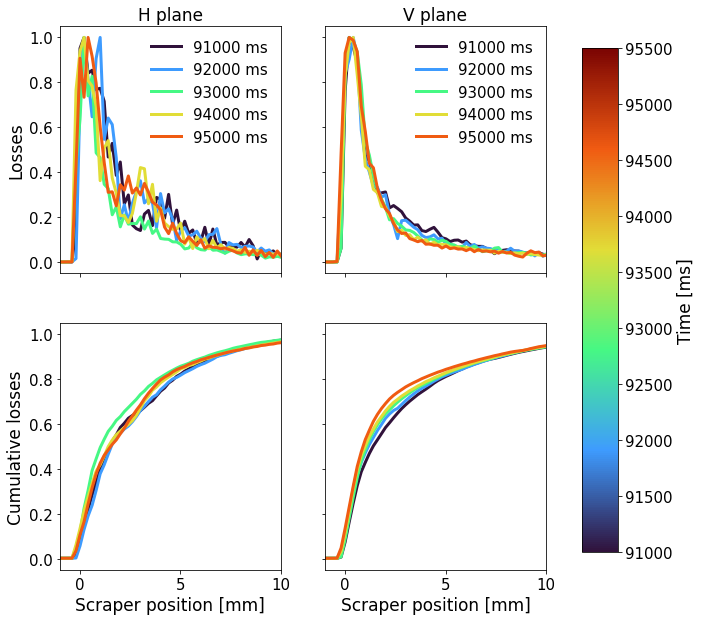

In [53]:
f, ax = plt.subplots(2, 2, figsize = (10, 10), sharex = True, sharey = True)

normalize = mpl.colors.Normalize(vmin=91000, vmax=95500)
colormap = mpl.cm.turbo(np.linspace(0,1,6))

ax1, ax2 = ax[0,0], ax[0,1]
ax3, ax4 = ax[1,0], ax[1,1]
j = 0

for h, data in enumerate(df_100["startScraperDelay"].values):
    
    ScraperStart = np.where(np.diff(np.array(df_100.scraperY.iloc[h]))<-0.03)[0][0]
    ScraperEnd = np.where(np.diff(np.array(df_100.scraperY.iloc[h]))<-0.03)[0][-1]

    delta_time_scraper = np.abs(df_100.scraperXms.iloc[h][ScraperStart] - df_100.scraperXms.iloc[h][ScraperEnd] )

    VelocityScraper = (max(df_100.scraperY.iloc[h]) - min(df_100.scraperY.iloc[h])) / delta_time_scraper
    
    ydata_scalar = np.array(df_100["det1.yval"].iloc[h][1])[::-1]
    xdata_scalar = np.array(df_100["det1.xms"].iloc[h]) * VelocityScraper
    
    limit = 0.01
    
    ind_minlosses = np.where(ydata_scalar/max(ydata_scalar)>limit)[0][0]+1
    
    if 1:#(df_100.iloc[h]["startScraperDelay"]<96000) or (df_100.iloc[h]["startScraperDelay"]>97000): 
    
        if (df_100.iloc[h]["scraperDirection"] == "Int") or (df_100.iloc[h]["scraperDirection"] == "Ext") :
            ax1.plot(xdata_scalar - xdata_scalar[ind_minlosses], 
                     ydata_scalar/max(ydata_scalar), "-",
                     color = colormap[j], lw = 3, label = "%1.0f ms"%df_100.iloc[h]["startScraperDelay"])
            
#             ax3.plot(xdata_scalar - xdata_scalar[ind_minlosses], 
#                      np.cumsum(ydata_scalar)/np.trapz(ydata_scalar, x = xdata_scalar - xdata_scalar[ind_minlosses], 
#                   dx = np.diff(xdata_scalar - xdata_scalar[ind_minlosses]) )/5, 
#                      "-", color = colormap[j], lw = 3)
            
            ax3.plot(xdata_scalar - xdata_scalar[ind_minlosses], np.cumsum(ydata_scalar)/max(np.cumsum(ydata_scalar)),
                     "-", color = colormap[j], lw = 3)
            print("H",np.trapz(ydata_scalar, x = xdata_scalar - xdata_scalar[ind_minlosses], 
                   dx = np.diff(xdata_scalar - xdata_scalar[ind_minlosses])))
        else:
            ax2.plot(xdata_scalar - xdata_scalar[ind_minlosses], 
                     ydata_scalar/max(ydata_scalar), "-", 
                     color = colormap[j], lw = 3, label = "%1.0f ms"%df_100.iloc[h]["startScraperDelay"])
            
#             ax4.plot(xdata_scalar - xdata_scalar[ind_minlosses],
#                     np.cumsum(ydata_scalar)/np.trapz(ydata_scalar, x = xdata_scalar - xdata_scalar[ind_minlosses], 
#                   dx = np.diff(xdata_scalar - xdata_scalar[ind_minlosses]) )/5, 
#                     "-", color = colormap[j], lw = 3)
            ax4.plot(xdata_scalar - xdata_scalar[ind_minlosses], np.cumsum(ydata_scalar)/max(np.cumsum(ydata_scalar)), 
                     "-", color = colormap[j], lw = 3)
    
            print("V", np.trapz(ydata_scalar, x = xdata_scalar - xdata_scalar[ind_minlosses], 
                           dx = np.diff(xdata_scalar - xdata_scalar[ind_minlosses])))
            
            j += 1

# ax3.plot([-1,15],[0.95, 0.95], "-k")
# ax4.plot([-1,15],[0.95, 0.95], "-k")
            
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', colormap)
norm = mpl.colors.Normalize(91000, 95500)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

f.subplots_adjust(right=0.8)
cbar = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(sm, ax=ax[:, 1], cax=cbar)
cbar.set_ylabel("Time [ms]", size = 17)
cbar.tick_params(labelsize=15)
        
ax1.set_xlim([-1, 10])
ax2.set_xlim([-1, 10])
ax3.set_xlim([-1, 10])
ax4.set_xlim([-1, 10])

ax1.set_title ("H plane", size = 17)
ax2.set_title ("V plane", size = 17)

ax1.set_ylabel ("Losses", size = 17)
ax3.set_ylabel ("Cumulative losses", size = 17)

ax3.set_xlabel("Scraper position [mm]", size = 17)
ax4.set_xlabel("Scraper position [mm]", size = 17)

ax1.tick_params(axis = "both", which = "major", labelsize = 15)
ax2.tick_params(axis = "both", which = "major", labelsize = 15)
ax3.tick_params(axis = "both", which = "major", labelsize = 15)
ax4.tick_params(axis = "both", which = "major", labelsize = 15)

ax1.legend(frameon = False, prop = {"size":15})
ax2.legend(frameon = False, prop = {"size":15})

# f.savefig("./EvolutionTailsEcooling100MeVc.pdf")

In [45]:
H_int = np.array([114639.66954434018, 94657.22372450434, 106132.316443277, 90672.01591846903, 91161.46527815016])
V_int = np.array([133708.6644699796, 120720.71150340047, 123842.68311065201, 113641.8867374139, 118580.3780803803])
Time = [91, 92, 93, 94, 95]

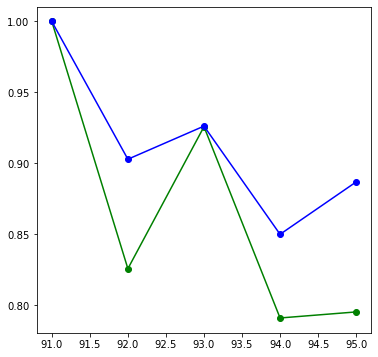

In [46]:
f, ax = plt.subplots(1, 1, figsize = (6, 6)) 

ax.plot(Time, H_int/max(H_int), "o-g")
ax.plot(Time, V_int/max(V_int), "o-b")